
# Numerical simulations and Markov Chain Monte Carlo (MCMC)

**Goals**
- Understand why many posteriors are not closed form and what to do instead  
- Compute posteriors numerically via **grid approximation** (and see where it breaks)  
- Approximate posterior expectations via **Monte Carlo from the prior** with importance weighting  
- Implement and tune **Metropolis MCMC** for a Beta–Binomial model  
- Diagnose chains with **trace**, **autocorrelation**, **$\hat R$**, and **Effective Sample Size (ESS)**  
- Brief outlook to **HMC/NUTS**



## Why computing posteriors can be hard

Bayes with densities:
$$
p(\theta \mid d)=\frac{p(d\mid\theta)p(\theta)}{p(d)},\qquad
p(d)=\int p(d\mid\theta)p(\theta)\,d\theta.
$$

The evidence $p(d)$ is often an intractable integral, especially with multiple parameters, non-conjugate priors, and complex likelihoods. We use **numerical** strategies.


## Utilities

In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

def with_ax(title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

def beta_pdf(x, a, b):
    from math import lgamma
    x = np.asarray(x)
    out = np.zeros_like(x, dtype=float)
    m = (x>=0) & (x<=1)
    xm = x[m]
    logB = lgamma(a)+lgamma(b)-lgamma(a+b)
    out[m] = np.exp((a-1)*np.log(xm+1e-15) + (b-1)*np.log(1-xm+1e-15) - logB)
    return out



## Grid approximation for a Beta–Binomial posterior

Target: the posterior of a proportion $\pi \in [0,1]$ given $n$ trials and $k$ successes, with prior $\mathrm{Beta}(\alpha,\beta)$. We evaluate prior and likelihood on a fine grid and renormalize.


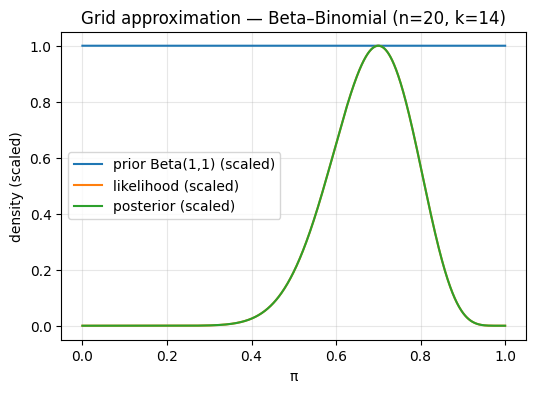

In [2]:

def beta_binomial_grid(alpha, beta, n, k, m=2000):
    xs = np.linspace(0,1,m)
    prior = beta_pdf(xs, alpha, beta)
    like_u = xs**k * (1-xs)**(n-k)  # unnormalized likelihood
    post_u = prior * like_u
    Z = np.trapz(post_u, xs)
    post = post_u / (Z + 1e-15)
    return xs, prior, like_u / (like_u.max()+1e-15), post

alpha,beta = 1,1
n,k = 20, 14
xs, pr, lk, po = beta_binomial_grid(alpha,beta,n,k)

fig, ax = with_ax(title="Grid approximation — Beta–Binomial (n=20, k=14)", xlabel="π", ylabel="density (scaled)")
ax.plot(xs, pr/pr.max(), label=f"prior Beta({alpha},{beta}) (scaled)")
ax.plot(xs, lk, label="likelihood (scaled)")
ax.plot(xs, po/po.max(), label="posterior (scaled)")
ax.legend(); plt.show()



### More data $\Rightarrow$ narrower posterior (and a denser grid may be needed)


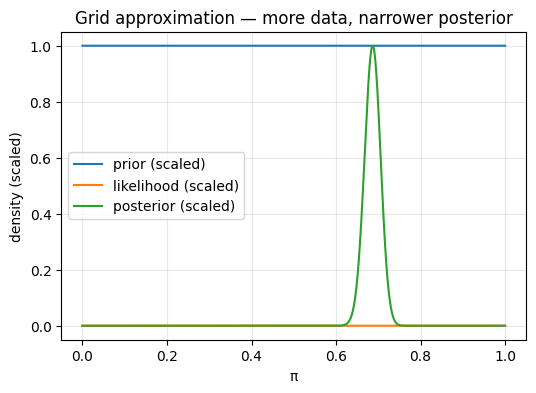

In [3]:

alpha,beta = 1,1
n2,k2 = 600, 412
xs2, pr2, lk2, po2 = beta_binomial_grid(alpha,beta,n2,k2, m=4000)

fig, ax = with_ax(title="Grid approximation — more data, narrower posterior", xlabel="π", ylabel="density (scaled)")
ax.plot(xs2, pr2/pr2.max(), label="prior (scaled)")
ax.plot(xs2, lk2, label="likelihood (scaled)")
ax.plot(xs2, po2/po2.max(), label="posterior (scaled)")
ax.legend(); plt.show()



### Why naive grids do not scale well

To keep $N$ points per dimension (fixed resolution), a $d$-dimensional grid needs $N^d$ points: the **curse of dimensionality**.


In [4]:

def grid_points(N, d, dt_ms=0.1):
    pts = N**d
    ms = pts*dt_ms
    return pts, ms/1000, ms/1000/60, ms/1000/3600, ms/1000/86400

N = 100
dims = [1,2,3,4,5,6,8,10]
print("d | points (N^d) | sec | min | hours | days")
for d in dims:
    pts, sec, mins, hours, days = grid_points(N, d)
    print(f"{d:>2} | {pts:>14,d} | {sec:>7.1f} | {mins:>6.2f} | {hours:>7.2f} | {days:>6.2f}")


d | points (N^d) | sec | min | hours | days
 1 |            100 |     0.0 |   0.00 |    0.00 |   0.00
 2 |         10,000 |     1.0 |   0.02 |    0.00 |   0.00
 3 |      1,000,000 |   100.0 |   1.67 |    0.03 |   0.00
 4 |    100,000,000 | 10000.0 | 166.67 |    2.78 |   0.12
 5 | 10,000,000,000 | 1000000.0 | 16666.67 |  277.78 |  11.57
 6 | 1,000,000,000,000 | 100000000.0 | 1666666.67 | 27777.78 | 1157.41
 8 | 10,000,000,000,000,000 | 1000000000000.0 | 16666666666.67 | 277777777.78 | 11574074.07
10 | 100,000,000,000,000,000,000 | 10000000000000000.0 | 166666666666666.66 | 2777777777777.78 | 115740740740.74



## Monte Carlo from the prior with importance weighting

Sample $\pi^{(i)}\sim p(\pi)$ from the prior and weight by $w_i \propto p(d\mid \pi^{(i)})$.  
A self-normalized estimator for $E[\pi\mid d]$ is $\sum_i \tilde w_i \pi^{(i)}$ with $\tilde w_i = w_i/\sum_j w_j$.  
This can be inefficient if prior mass misses the likelihood’s high-probability region.


In [5]:

def mc_from_prior(alpha, beta, n, k, N=100_000, seed=123):
    rng = np.random.default_rng(seed)
    pis = rng.beta(alpha, beta, size=N)
    w = pis**k * (1-pis)**(n-k)
    w = w / (w.mean() + 1e-15)       # stabilize scale
    wsn = w / (w.sum() + 1e-15)      # self-normalized weights
    est = np.sum(wsn * pis)          # posterior mean estimate
    ess = 1.0 / (np.sum(wsn**2) + 1e-15)  # importance ESS
    return pis, wsn, est, int(ess)

n,k = 20,14
pis1, w1, est1, ess1 = mc_from_prior(1,1,n,k)
pis2, w2, est2, ess2 = mc_from_prior(14,6,n,k)
print("Flat prior  Beta(1,1):    E[π|d]≈", round(est1,4), "   ESS≈", ess1)
print("Stronger prior Beta(14,6): E[π|d]≈", round(est2,4), "   ESS≈", ess2)


Flat prior  Beta(1,1):    E[π|d]≈ 0.6818    ESS≈ 34694
Stronger prior Beta(14,6): E[π|d]≈ 0.6999    ESS≈ 86162


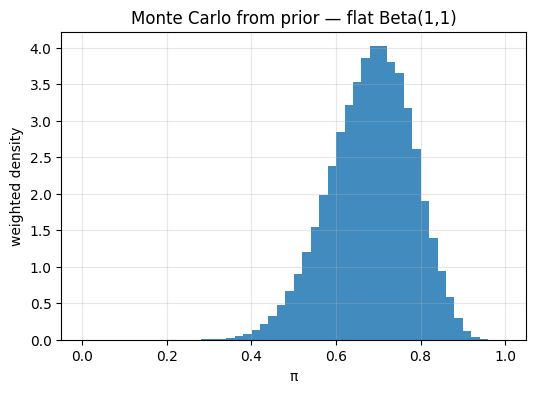

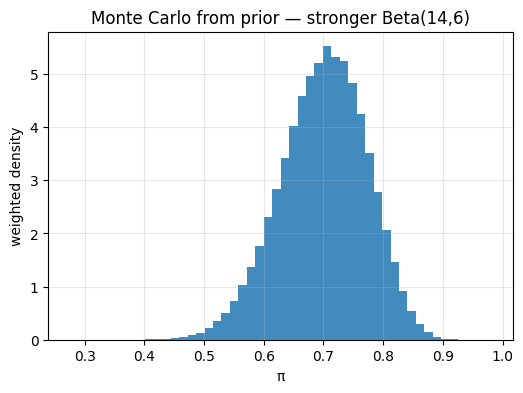

In [6]:

def weighted_hist(x, w, bins=50, title=""):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title(title); ax.set_xlabel("π"); ax.set_ylabel("weighted density")
    ax.hist(x, bins=bins, weights=w, density=True, alpha=0.85)
    ax.grid(True, alpha=0.3); plt.show()

weighted_hist(pis1, w1, title="Monte Carlo from prior — flat Beta(1,1)")
weighted_hist(pis2, w2, title="Monte Carlo from prior — stronger Beta(14,6)")



## Metropolis MCMC for a Beta–Binomial posterior

We target $p(\pi\mid d)\propto p(d\mid\pi)p(\pi)$ and use a symmetric Gaussian random walk proposal reflected to $[0,1]$.
The Metropolis acceptance probability is
$$
\alpha(\pi\to\pi')=\min\!\left(1,\ \frac{p(d\mid\pi')p(\pi')}{p(d\mid\pi)\,p(\pi)}\right).
$$
We only need **ratios** of posteriors, so there is no need to compute $p(d)$.


In [7]:

def log_beta_prior(pi, a, b):
    if pi<=0 or pi>=1: return -np.inf
    return (a-1)*np.log(pi) + (b-1)*np.log(1-pi)

def log_binom_like(pi, n, k):
    if pi<=0 or pi>=1: return -np.inf
    return k*np.log(pi) + (n-k)*np.log(1-pi)

def metropolis_beta_binom(alpha, beta, n, k, N=10_000, sigma=0.1, seed=1, init=0.5, burn=1000):
    rng = np.random.default_rng(seed)
    x = np.empty(N+burn)
    x[0] = init
    acc = 0
    cur = x[0]
    cur_lp = log_beta_prior(cur, alpha,beta) + log_binom_like(cur, n,k)
    for t in range(1, N+burn):
        prop = cur + rng.normal(0, sigma)
        # reflect to [0,1]
        if prop < 0:  prop = -prop
        if prop > 1:  prop = 2 - prop
        prop_lp = log_beta_prior(prop, alpha,beta) + log_binom_like(prop, n,k)
        if np.log(rng.uniform()) < (prop_lp - cur_lp):
            cur, cur_lp = prop, prop_lp
            acc += 1
        x[t] = cur
    chain = x[burn:]
    return chain, acc/(N+burn-1)

# Run a chain
n,k = 10, 8
alpha,beta = 5, 2
chain, ar = metropolis_beta_binom(alpha,beta,n,k, N=20_000, sigma=0.1, seed=42, init=0.4, burn=2_000)
print("Acceptance rate:", round(ar,3), "Chain length:", len(chain))


Acceptance rate: 0.717 Chain length: 20000


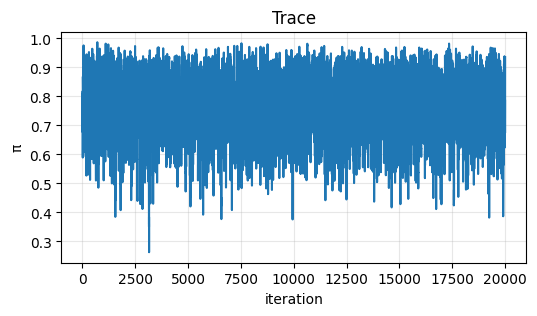

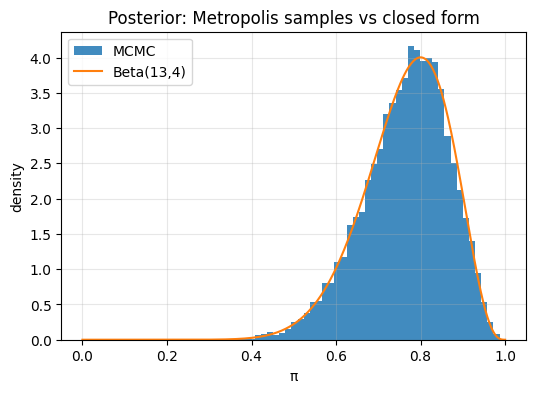

In [8]:

# Trace plot
fig, ax = plt.subplots(figsize=(6,3))
ax.set_title("Trace")
ax.set_xlabel("iteration"); ax.set_ylabel("π")
ax.plot(chain)
ax.grid(True, alpha=0.3); plt.show()

# Histogram vs closed-form Beta posterior
def beta_post_params(alpha,beta,n,k):
    return alpha+k, beta+(n-k)

a1,b1 = beta_post_params(alpha,beta,n,k)
xs = np.linspace(0,1,400)
true_post = beta_pdf(xs, a1,b1)
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title("Posterior: Metropolis samples vs closed form")
ax.set_xlabel("π"); ax.set_ylabel("density")
ax.hist(chain, bins=50, density=True, alpha=0.85, label="MCMC")
ax.plot(xs, true_post/np.trapz(true_post, xs), label=f"Beta({a1},{b1})")
ax.grid(True, alpha=0.3); ax.legend(); plt.show()



### Tuning the proposal scale $\sigma$

- Too large $\sigma$ $\Rightarrow$ low acceptance, sticky chain  
- Too small $\sigma$ $\Rightarrow$ tiny moves, strong autocorrelation


σ=0.01: acceptance≈0.966, len=8000
σ=0.1: acceptance≈0.723, len=8000
σ=0.8: acceptance≈0.314, len=8000


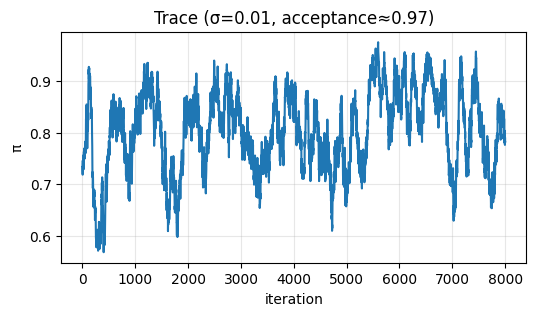

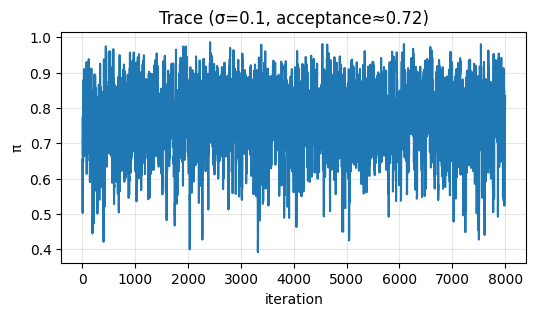

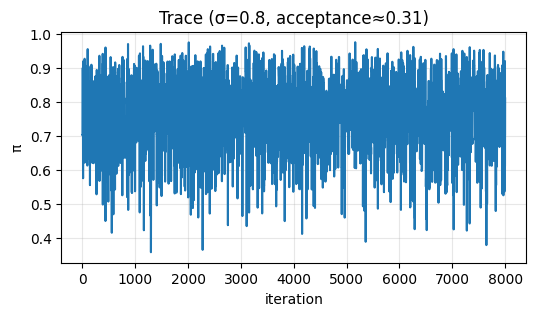

In [9]:

def run_sigma_demo(sigmas=(0.01, 0.1, 0.8)):
    results = []
    for s in sigmas:
        ch, ar = metropolis_beta_binom(alpha,beta,n,k, N=8_000, sigma=s, seed=123, init=0.4, burn=1_000)
        results.append((s, ch, ar))
    return results

demos = run_sigma_demo()
for s,ch,ar in demos:
    print(f"σ={s}: acceptance≈{ar:.3f}, len={len(ch)}")

for s,ch,ar in demos:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.set_title(f"Trace (σ={s}, acceptance≈{ar:.2f})")
    ax.set_xlabel("iteration"); ax.set_ylabel("π")
    ax.plot(ch); ax.grid(True, alpha=0.3); plt.show()



## Diagnostics: autocorrelation, $\hat R$, and ESS

Good chains **mix**, show dropping autocorrelation, have $\hat R \approx 1$, and a decent **ESS/N**.

We implement simple versions of these diagnostics for one and multiple chains.


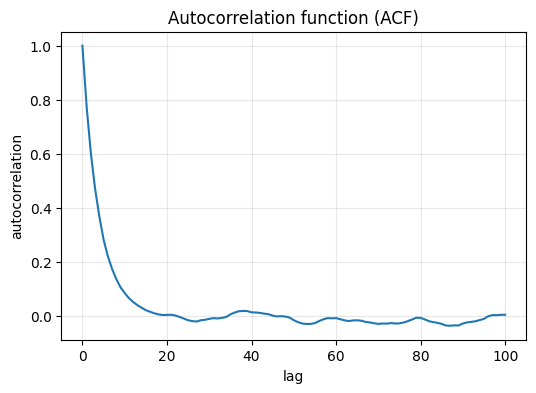

In [10]:

def acf(x, max_lag=100):
    x = np.asarray(x)
    x = x - x.mean()
    var = np.dot(x, x)
    ac = np.empty(max_lag+1)
    for lag in range(max_lag+1):
        ac[lag] = np.dot(x[:-lag or None], x[lag:]) / (var + 1e-15)
    return ac

ac = acf(chain, max_lag=100)
fig, ax = with_ax(title="Autocorrelation function (ACF)", xlabel="lag", ylabel="autocorrelation")
ax.plot(np.arange(len(ac)), ac)
plt.show()


In [11]:

def rhat_ess(chains):
    # chains: list of 1D numpy arrays (assumed same length)
    # Returns (rhat, ess) where ess uses a simple positive-sequence ACF sum.
    m = len(chains)
    n = min(map(len, chains))
    xs = np.array([c[:n] for c in chains])
    # R-hat
    chain_means = xs.mean(axis=1)
    grand_mean  = chain_means.mean()
    B = n * ((chain_means - grand_mean)**2).sum() / (m - 1 + 1e-15)
    W = (xs.var(axis=1, ddof=1)).mean()
    var_hat = ( (n-1)/n ) * W + B/n
    rhat = np.sqrt(var_hat / (W + 1e-15))
    # ESS via integrated autocorrelation time (rough)
    def tau_int(ac):
        s = 0.0
        for lag in range(1, len(ac)):
            if ac[lag] <= 0: break
            s += 2*ac[lag]
        return 1.0 + s
    taus = [tau_int(acf(c, max_lag=min(1000, n-1))) for c in xs]
    tau = np.max(taus)  # conservative
    ess = m*n / tau
    return float(rhat), float(ess)

# Run 4 chains
chains = []
for sd in [1, 7, 21, 77]:
    ch, _ = metropolis_beta_binom(alpha,beta,n,k, N=15_000, sigma=0.1, seed=sd, init=0.2+0.2*(sd%3), burn=2_000)
    chains.append(ch)

rhat, ess = rhat_ess(chains)
print("R-hat≈", round(rhat,3), "  ESS≈", int(ess), "  ESS/N per chain≈", round(ess/(len(chains)*len(chains[0])),3))


R-hat≈ 1.0   ESS≈ 5367   ESS/N per chain≈ 0.089


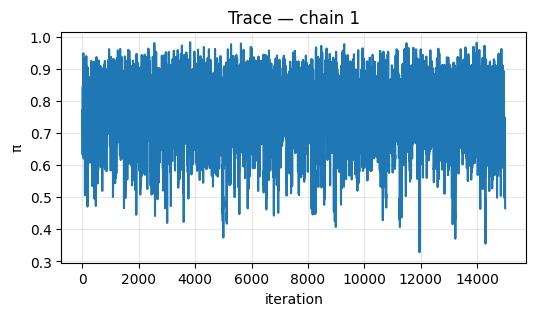

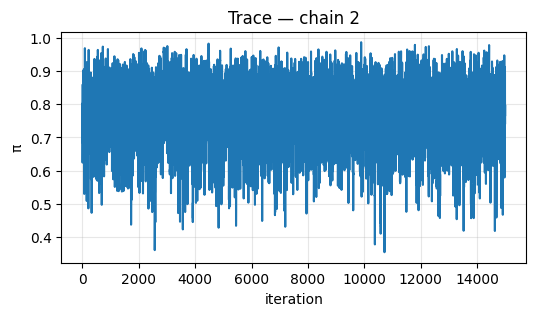

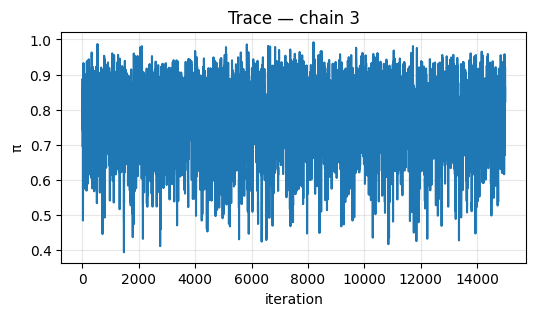

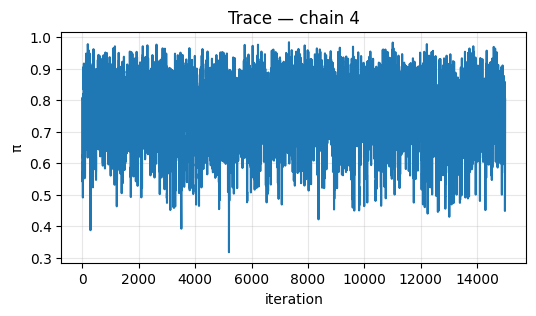

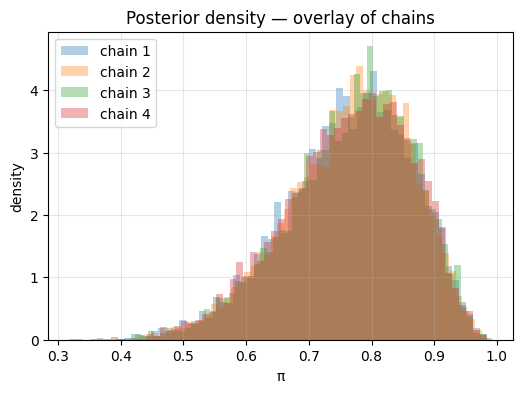

In [12]:

# Visualize chains
for i, ch in enumerate(chains, 1):
    fig, ax = plt.subplots(figsize=(6,3))
    ax.set_title(f"Trace — chain {i}")
    ax.set_xlabel("iteration"); ax.set_ylabel("π")
    ax.plot(ch); ax.grid(True, alpha=0.3); plt.show()

fig, ax = with_ax(title="Posterior density — overlay of chains", xlabel="π", ylabel="density")
for i, ch in enumerate(chains, 1):
    ax.hist(ch, bins=60, density=True, alpha=0.35, label=f"chain {i}")
ax.legend(); plt.show()



## Comparing numerical strategies

We compare the posterior mean from grid approximation, Monte Carlo from the prior (importance), and MCMC.


In [13]:

# Grid posterior mean
xs, pr, lk, po = beta_binomial_grid(alpha,beta,n,k, m=4000)
grid_mean = np.trapz(xs*po, xs)

# Importance MC
pis_imp, w_imp, est_imp, ess_imp = mc_from_prior(alpha,beta,n,k, N=150_000, seed=999)

# MCMC posterior mean
mcmc_mean = chain.mean()

print("Posterior mean estimates")
print("Grid:           ", round(grid_mean, 5))
print("MC (importance):", round(est_imp, 5), "  ESS≈", ess_imp)
print("MCMC:           ", round(mcmc_mean, 5), "  n_samples=", len(chain))


Posterior mean estimates
Grid:            0.76471
MC (importance): 0.76486   ESS≈ 117243
MCMC:            0.76445   n_samples= 20000



## Outlook: HMC and NUTS

Random-walk Metropolis scales poorly in higher dimensions. **Hamiltonian Monte Carlo (HMC)** uses gradients to take long, informed moves with higher acceptance; **NUTS** adapts path lengths automatically. Modern probabilistic programming systems (e.g., Stan, NumPyro, PyMC) implement these methods.
